# Categorizing Fake News (Case Study)

### Setting the Scene

Imagine you are working for a social media company. The company is concerned with the growing amount of fake news circulatng on it's platform. They have assigned you to investigate how fake news can be recognized and create a method of identifying it. Let's work through this problem together, first by exploring and cleaning the data and then working to classify fake vs factual news stories. We'll also create some plots of our outputs and discuss how we would communicate our findings to stakeholders.

---

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
upload = files.upload()

Saving fake_news_data.csv to fake_news_data (1).csv


In [ ]:
data = pd.read_csv("fake_news_data.csv")

data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


Text(0.5, 0, 'Classification')

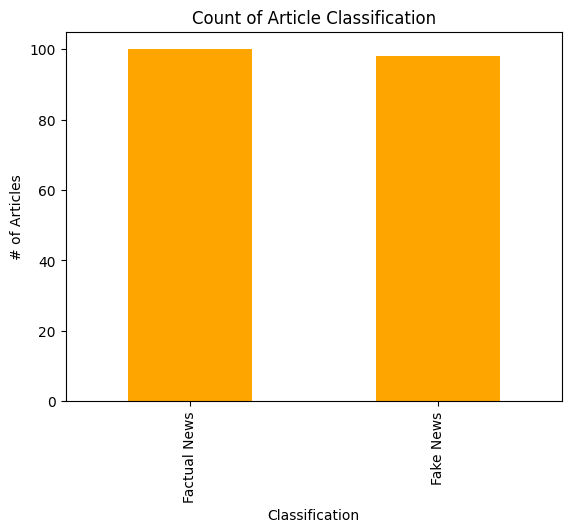

In [ ]:
data['fake_or_factual'].value_counts().plot(kind='bar', color='orange')
plt.title('Count of Article Classification')
plt.ylabel('# of Articles')
plt.xlabel('Classification')

In [ ]:
import seaborn as sns   # for data visualization (heatmaps, plots, etc.)
import spacy            # for advanced NLP tasks (tokenization, NER, POS tagging)
from spacy import displacy   # for visualizing NLP results (dependency parsing, named entities)
from spacy import tokenizer  # for tokenizing text using spaCy
import re               # for regex (cleaning text, removing patterns like punctuation)
import nltk             # Natural Language Toolkit (basic NLP tasks)
from nltk.tokenize import word_tokenize   # split text into words
from nltk.stem import PorterStemmer, WordNetLemmatizer  # stemming and lemmatization
from nltk.corpus import stopwords          # list of common words to remove (like "the", "is")
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # sentiment analysis (pretrained rule-based)

import gensim          # topic modeling + NLP (LDA, LSA, etc.)
import gensim.corpora as corpora   # to create dictionaries and bag-of-words for models
from gensim.models.coherencemodel import CoherenceModel   # measure quality of topics (LDA/LSA)
from gensim.models import LsiModel, TfidfModel  # LSA model, TF-IDF model

from sklearn.feature_extraction.text import TfidfVectorizer   # convert text → TF-IDF vectors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer   # convert text → count vectors or TF-IDF
from sklearn.model_selection import train_test_split   # split dataset into train/test
from sklearn.linear_model import LogisticRegression, SGDClassifier   # ML models for classification
from sklearn.metrics import accuracy_score, classification_report   # evaluation metrics for classification


#### POS Tagging

In [ ]:
# This model can do: tokenization, part-of-speech tagging, named entity recognition (NER), lemmatization, etc.
nlp = spacy.load('en_core_web_sm')

In [ ]:
# split data by fake and factual news
fake_news = data[data['fake_or_factual'] == "Fake News"]
fact_news = data[data['fake_or_factual'] == "Factual News"]

In [ ]:
# create spacey documents - use pipe for dataframe
fake_spaceydocs = list(nlp.pipe(fake_news['text']))
fact_spaceydocs = list(nlp.pipe(fact_news['text']))

In [ ]:
# create function to extract tags for each document in our data
def extract_token_tags(doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [ ]:
# tag fake dataset
fake_tagsdf = []
columns = ["token", "ner_tag", "pos_tag"]

for ix, doc in enumerate(fake_spaceydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags, columns=columns)
    fake_tagsdf.append(tags)

fake_tagsdf = pd.concat(fake_tagsdf)

# tag factual dataset
fact_tagsdf = []

for ix, doc in enumerate(fact_spaceydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags, columns=columns)
    fact_tagsdf.append(tags)

fact_tagsdf = pd.concat(fact_tagsdf)

In [ ]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [ ]:
# token frequency count (fake)
pos_counts_fake = fake_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [ ]:
# frequencies of pos tags
pos_counts_fake.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)

,token
pos_tag,
NOUN,2586
VERB,1817
PROPN,1672
ADJ,882
ADV,413
NUM,221
PRON,96
ADP,89
AUX,62


In [ ]:
# dive into diferences in nouns
pos_counts_fake[pos_counts_fake.pos_tag == "NOUN"][0:15]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


## Named Entities

In [ ]:
# top entities in fake news
top_entities_fake = (
    fake_tagsdf[fake_tagsdf['ner_tag'] != ""]
    .groupby(['token','ner_tag'])
    .size()
    .reset_index(name='counts')
    .sort_values(by='counts', ascending=False)
)
top_entities_fake

,token,ner_tag,counts
1730,Trump,PERSON,154
1729,Trump,ORG,152
2129,the,ORG,121
592,Clinton,PERSON,118
718,Donald,PERSON,75
...,...,...,...
886,Hempstead,GPE,1
885,Helbig,PERSON,1
884,Hedge,PERSON,1
883,Heather,PERSON,1


In [ ]:
# top entities in fact news
top_entities_fact = (
    fact_tagsdf[fact_tagsdf['ner_tag'] != ""]
    .groupby(['token','ner_tag'])
    .size()
    .reset_index(name='counts')
    .sort_values(by='counts', ascending=False)
)

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

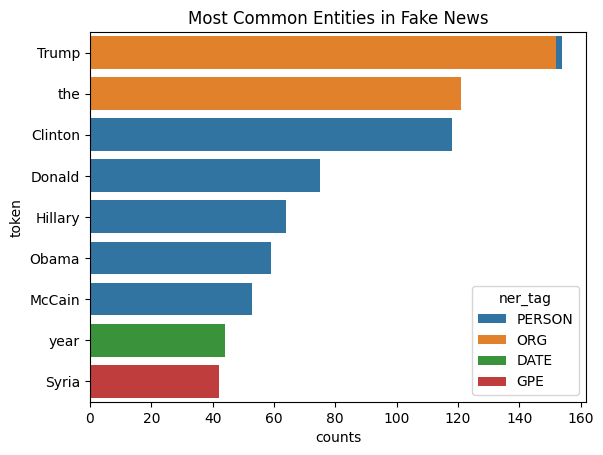

In [ ]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    data = top_entities_fake[0:10],
    orient = 'h',
    dodge=False
).set(title='Most Common Entities in Fake News')

[Text(0.5, 1.0, 'Most Common Entities in Factual News')]

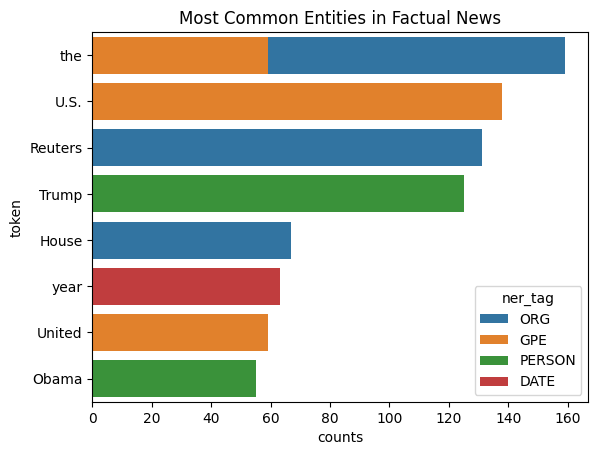

In [ ]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    data = top_entities_fact[0:10],
    orient = 'h',
    dodge=False
).set(title='Most Common Entities in Factual News')

## Text Pre-processing

In [ ]:
# a lot of the factual news has a location tag at the beginning of the article, let's use regex to remove this
data['text_clean'] = data.apply(lambda x: re.sub(r"^[^-]*-\s*", "", x['text']), axis=1)

In [ ]:
# lowercase
data['text_clean'] = data['text_clean'].str.lower()

In [ ]:
# remove punctuation
data['text_clean'] = data.apply(lambda x: re.sub(r"([^\w\s])", "", x['text_clean']), axis=1)

In [ ]:
# stop words
en_stopwords = stopwords.words('english')
print(en_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [ ]:
data['text_clean'] = data['text_clean'] .apply(lambda x: ' '.join([word for word in x.split() if word not in en_stopwords]))

In [ ]:
# tokenize
data['text_clean'] = data.apply(lambda x: word_tokenize(x['text_clean']), axis=1)

In [ ]:
# lemmatize
lemmatizer = WordNetLemmatizer()
data["text_clean"] = data["text_clean"].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [ ]:
# most common unigrams after preprocessing
tokens_clean = sum(data['text_clean'], [])
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()).reset_index()[:10]
print(unigrams)

          index  count
0       (said,)    560
1      (trump,)    451
2         (us,)    255
3  (president,)    214
4      (would,)    210
5        (one,)    132
6      (state,)    131
7       (also,)    124
8     (states,)    119
9    (clinton,)    113


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

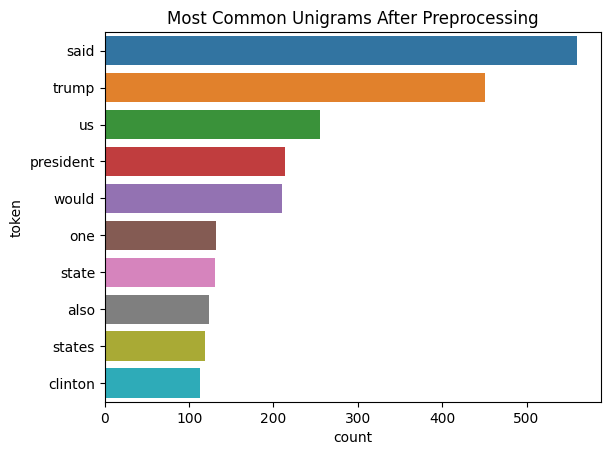

In [ ]:

unigrams['token'] = unigrams['index'].apply(lambda x: x[0]) # extract the token from the tuple so we can plot it

sns.barplot(x = "count",
            y = "token",
            data=unigrams,
            orient = 'h',
            hue = "token",
            legend = False
          ).set(title='Most Common Unigrams After Preprocessing')

In [ ]:
# most common bigrams after preprocessing
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()).reset_index()
bigrams[:10]

,index,count
0,"(united, states)",80
1,"(donald, trump)",76
2,"(white, house)",71
3,"(president, donald)",42
4,"(new, york)",31
5,"(image, via)",29
6,"(hillary, clinton)",29
7,"(supreme, court)",25
8,"(told, reporters)",22
9,"(north, korea)",21


### Sentiment Analysis

In [ ]:
# use vader so we also get a neutral sentiment count
vader_sentiment = SentimentIntensityAnalyzer()

In [ ]:
data['vader_sentiment_score'] = data['text'].apply(lambda review: vader_sentiment.polarity_scores(review)['compound'])

<Axes: xlabel='vader_sentiment_label'>

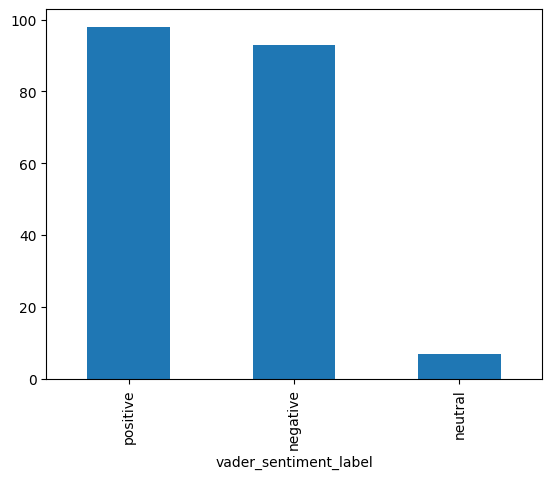

In [ ]:
# create labels
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)


data['vader_sentiment_label'].value_counts().plot.bar()

/tmp/ipython-input-4088581074.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

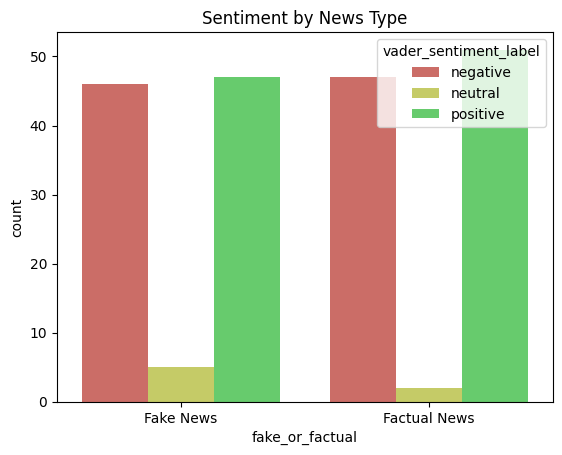

In [ ]:
sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    palette = sns.color_palette("hls"),
    data = data
).set(title='Sentiment by News Type')

### LDA

In [ ]:
# fake news data vectorization
fake_news_text = data[data['fake_or_factual'] == "Fake News"]['text_clean'].reset_index(drop=True)
dictionary_fake = corpora.Dictionary(fake_news_text)
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

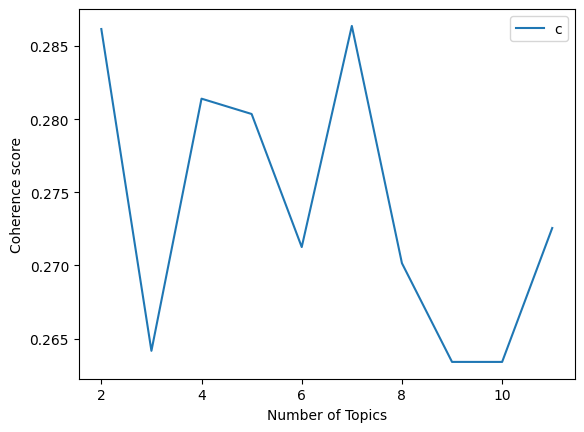

In [ ]:
# generate coherence scores to determine an optimum number of topics
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# create lda model
num_topics_fake = 6

lda_model_fake = gensim.models.LdaModel(corpus=doc_term_fake,
                                       id2word=dictionary_fake,
                                       num_topics=num_topics_fake)

lda_model_fake.print_topics(num_topics=num_topics_fake, num_words=10)

[(0,
  '0.013*"trump" + 0.004*"clinton" + 0.004*"said" + 0.004*"would" + 0.003*"president" + 0.003*"like" + 0.003*"people" + 0.003*"us" + 0.003*"also" + 0.003*"syria"'),
 (1,
  '0.009*"trump" + 0.004*"said" + 0.003*"clinton" + 0.003*"would" + 0.003*"people" + 0.003*"us" + 0.003*"president" + 0.003*"one" + 0.002*"even" + 0.002*"also"'),
 (2,
  '0.014*"trump" + 0.006*"said" + 0.004*"president" + 0.003*"would" + 0.003*"hillary" + 0.003*"one" + 0.003*"clinton" + 0.003*"two" + 0.002*"us" + 0.002*"also"'),
 (3,
  '0.012*"trump" + 0.004*"said" + 0.004*"president" + 0.004*"would" + 0.003*"clinton" + 0.003*"people" + 0.003*"us" + 0.003*"one" + 0.003*"new" + 0.002*"republican"'),
 (4,
  '0.007*"trump" + 0.006*"said" + 0.004*"president" + 0.003*"clinton" + 0.003*"one" + 0.003*"us" + 0.003*"obama" + 0.003*"would" + 0.003*"told" + 0.002*"state"'),
 (5,
  '0.007*"trump" + 0.006*"clinton" + 0.004*"us" + 0.004*"president" + 0.004*"would" + 0.004*"said" + 0.003*"mccain" + 0.003*"obama" + 0.003*"one" + 

###  TF-IDF & LSA


In [ ]:
def tfidf_corpus(doc_term_matrix):
    # create a corpus using tfidf vecotization
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [ ]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    # generate coherence scores to determine an optimum number of topics
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word = dictionary, random_seed=0)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    # plot results
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

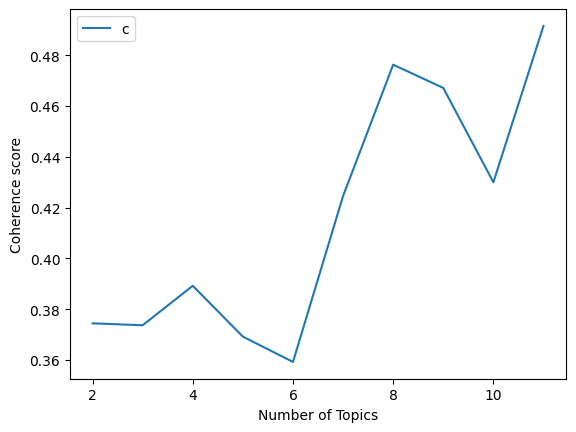

In [ ]:
# create tfidf representation
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)
# coherence scores for fake news data
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [ ]:
# model for fake news data
lsa_fake = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=5)
lsa_fake.print_topics()

[(0,
  '0.222*"trump" + 0.140*"clinton" + 0.087*"party" + 0.086*"president" + 0.086*"obama" + 0.085*"women" + 0.082*"said" + 0.079*"hillary" + 0.074*"republican" + 0.073*"donald"'),
 (1,
  '-0.295*"boiler" + -0.264*"room" + -0.247*"acr" + -0.184*"animals" + -0.174*"episode" + -0.146*"analysis" + -0.121*"jay" + -0.121*"dyer" + -0.118*"misguided" + -0.118*"masochists"'),
 (2,
  '-0.218*"clinton" + -0.139*"conference" + 0.137*"county" + -0.125*"hillary" + -0.123*"flynn" + 0.122*"school" + -0.116*"press" + -0.109*"dnc" + -0.098*"h" + -0.094*"september"'),
 (3,
  '-0.298*"flynn" + 0.176*"trump" + -0.107*"russian" + -0.105*"mccain" + -0.104*"department" + -0.100*"information" + 0.099*"bill" + 0.095*"pence" + -0.095*"emails" + -0.088*"30"'),
 (4,
  '-0.351*"flynn" + -0.206*"trump" + 0.148*"sanders" + -0.146*"conference" + 0.141*"clinton" + 0.124*"dnc" + -0.117*"press" + -0.099*"30" + -0.093*"nana" + 0.089*"rich"')]

## Predict fake or factual news

In [ ]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[women, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[us, defense, secretary, jim, mattis, said, mo...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, parties, rapidl...",0.8590,positive


In [ ]:
X = [','.join(map(str, l)) for l in data['text_clean']]
Y = data['fake_or_factual']

In [ ]:
# text vectorization - CountVectorizer
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns = countvec.get_feature_names_out())

In [ ]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size=0.3)

In [ ]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [ ]:
y_pred_lr = lr.predict(X_test)

accuracy_score(y_pred_lr, y_test)

0.8666666666666667

In [ ]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.81      0.97      0.88        31
   Fake News       0.96      0.76      0.85        29

    accuracy                           0.87        60
   macro avg       0.88      0.86      0.86        60
weighted avg       0.88      0.87      0.86        60



In [ ]:
svm = SGDClassifier().fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

accuracy_score(y_pred_svm, y_test)

0.85

In [ ]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.78      1.00      0.87        31
   Fake News       1.00      0.69      0.82        29

    accuracy                           0.85        60
   macro avg       0.89      0.84      0.84        60
weighted avg       0.88      0.85      0.85        60

